# Feature selection

In [1]:
from nltk.corpus import PlaintextCorpusReader

In [2]:
corpus_root = 'JOURNALISM.BG/C-MassMedia'
my_corpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
fileNames = my_corpus.fileids()

In [3]:
classesSet = set([file[:file.find('/')] for file in fileNames])
classes = sorted(list(classesSet - {'Z', 'D-Society'}))

In [4]:
def get_words(file):
    words = my_corpus.words(file)
    return words

full_class_corpus = [[get_words(file) for file in fileNames if file.find(c + '/') == 0] for c in classes]

In [15]:
from helper_funcs import bernoulli_classifier, multinomial_classifier, split_corpus, feature_selection, test_classifier

In [6]:
test_class_corpus, train_class_corpus = split_corpus.split_class_corpus(full_class_corpus)

In [7]:
condProbB, priorB, VB = bernoulli_classifier.train_bernoulli_NB(train_class_corpus)

[--------------------------------------------------]


In [10]:
condProbM, priorM, VM = multinomial_classifier.train_multinomial_NB(train_class_corpus)

[--------------------------------------------------]


In [11]:
Nc = [ len(classList) for classList in train_class_corpus ]

x = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000]

In [14]:
featureSetF = [feature_selection.select_features_by_frequency(VB,count) for count in x ]
InitialCondProbBFs = [ bernoulli_classifier.calc_initial_cond_prob(condProbB,features) for features in featureSetF]
featureSetM = [feature_selection.select_features_by_MI(Nc,VB,count) for count in x ]
InitialCondProbBMs = [ bernoulli_classifier.calc_initial_cond_prob(condProbB,features) for features in featureSetM]

In [ ]:
yBF = [test_classifier.test_classifier(test_class_corpus, lambda text : bernoulli_classifier.apply_bernoulli_NB(
    priorB, condProbB, InitialCondProbBFs[c], text, featureSetF[c]))[6] for c in range(len(featureSetF)) ]
yBM = [test_classifier.test_classifier(test_class_corpus, lambda text : bernoulli_classifier.apply_bernoulli_NB(
    priorB, condProbB, InitialCondProbBMs[c], text, featureSetM[c]))[6] for c in range(len(featureSetM)) ]
yMF = [test_classifier.test_classifier(test_class_corpus, lambda text : multinomial_classifier.apply_multinomial_NB(
    priorM, condProbM, text, features))[6] for features in featureSetF ]
yMM = [test_classifier.test_classifier(test_class_corpus, lambda text : multinomial_classifier.apply_multinomial_NB(
    priorM, condProbM, text, features))[6] for features in featureSetM ]

In [19]:
import matplotlib.pyplot as plt

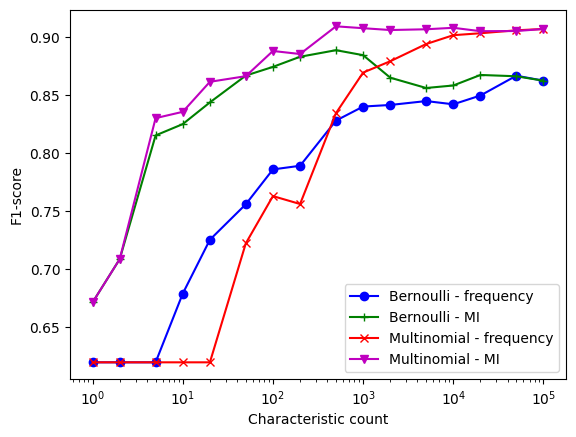

In [20]:
plt.plot(x,yBF,'-bo')
plt.plot(x,yBM,'-g+')
plt.plot(x,yMF,'-rx')
plt.plot(x,yMM,'-mv')
plt.ylabel('F1-score')
plt.xlabel('Characteristic count')
plt.xscale("log")
plt.legend(['Bernoulli - frequency','Bernoulli - MI','Multinomial - frequency','Multinomial - MI'])
plt.show()

In [21]:
cEco = classes.index('E-Economy')
cMil = classes.index('S-Military')
cCult = classes.index('C-Culture')
cPol = classes.index('J-Politics')

test_class_corpus_E = [test_class_corpus[cEco], test_class_corpus[cMil] ]
train_class_corpus_E = [train_class_corpus[cEco], train_class_corpus[cMil] ]

In [22]:
condProbBE, priorBE, VBE = bernoulli_classifier.train_bernoulli_NB(train_class_corpus_E)
condProbME, priorME, VME = multinomial_classifier.train_multinomial_NB(train_class_corpus_E)
NcE = [ len(classList) for classList in train_class_corpus_E ]

[--------------------------------------------------]
[--------------------------------------------------]


In [24]:
gamma = lambda text : multinomial_classifier.apply_multinomial_NB(priorME, condProbME, text)
confusionMatrix, precision, recall, Fscore, P, R, F1 = test_classifier.test_classifier(test_class_corpus_E, gamma)
print('Confusion matrix: ')
for row in confusionMatrix:
    for val in row:
        print('{:4}'.format(val), end = '')
    print()
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('F-scire: '+str(Fscore))
print('Overall precision: '+str(P)+', recall: '+str(R)+', F-score: '+str(F1))
print()

[-------------------------------------------------------]
Confusion matrix: 
  60   5
   4 154
Precision: [0.9375, 0.9685534591194969]
Recall: [0.9230769230769231, 0.9746835443037974]
F-scire: [0.9302325581395349, 0.9716088328075709]
Overall precision: 0.959502002425473, recall: 0.9596412556053812, F-score: 0.9595716239633164



In [25]:
featureSetE = feature_selection.select_features_by_MI(NcE,VBE,2)

In [28]:
gamma = lambda text : multinomial_classifier.apply_multinomial_NB(priorME, condProbME, text, featureSetE)
confusionMatrix, precision, recall, Fscore, P, R, F1 = test_classifier.test_classifier(test_class_corpus_E, gamma)
print('Confusion matrix: ')
for row in confusionMatrix:
    for val in row:
        print('{:4}'.format(val), end = '')
    print()
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('F-scire: '+str(Fscore))
print('Overall precision: '+str(P)+', recall: '+str(R)+', F-score: '+str(F1))
print()
print('Features = '+str(featureSetE))

[-------------------------------------------------------]
Confusion matrix: 
  21  44
   0 158
Precision: [1.0, 0.7821782178217822]
Recall: [0.3230769230769231, 1.0]
F-scire: [0.48837209302325585, 0.8777777777777778]
Overall precision: 0.8456688718199175, recall: 0.8026905829596414, F-score: 0.8236194329382259

Features = {'банка', 'военни'}


w=[4.552242736403306, -3.8661647982848426], b=-0.8890053230714332


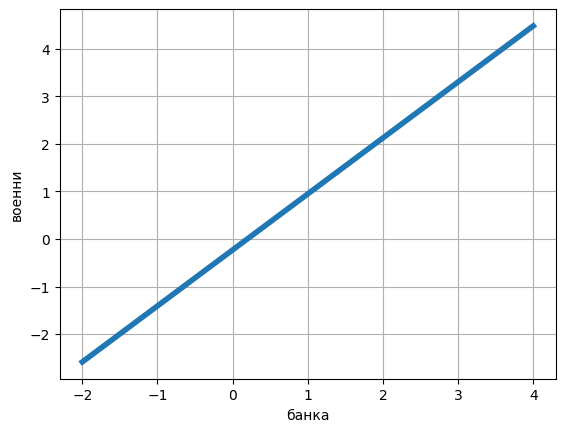

In [29]:
import math

featureListE = list(featureSetE)
b = math.log(priorME[0] / priorME[1])
w = [ math.log(condProbME[feature][0] / condProbME[feature][1]) for feature in featureListE]
print('w='+str(w)+', b='+str(b))

X = [*range(-2,5)]
Y = [ (-b - w[0] * x) / w[1] for x in X]
plt.plot(X,Y, linewidth=4)
plt.xlabel(featureListE[0])
plt.ylabel(featureListE[1])
plt.grid(True)
plt.show()